In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Stomach Cancer Diagnosis by Graph Neural Networks
# ##  PyTorch Implementation for GCN + TopKPooling with LeNet5 Architecture 
# ### Wang, Y. G. @UNSW, Dec 2019
# ### Yanan Wang, @Monash

# ## Main Program

# In[ ]:

# import os
import time
from matplotlib import pyplot as plt
import numpy as np
import scipy.io as sio
from sklearn.metrics import confusion_matrix
import matplotlib
import argparse
from sklearn.metrics import f1_score, accuracy_score, auc, roc_curve
import torch
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GraphConv, GINConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
# from torch.utils.data import random_split
# from torch_geometric.data import InMemoryDataset
# import matplotlib.pyplot as plt
# import pandas as pd

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_multi_label_confusion_matrix(_save_path, y_true, y_pred, labels, normalize=False, title=None, cmap=plt.cm.Blues):
    plt.close('all')
    plt.style.use("ggplot")
    plt.rcParams.update({'font.size': 8})
    plt.rcParams.update({'font.family':'Arial'})
    conf_mat_dict={}

    class_num = len(labels)

    plot_rows = int(class_num/4)+1
    plot_cols = 4 if class_num>=4 else class_num

    for label_col in range(class_num):
        y_true_label = y_true[:, label_col]
        y_pred_label = y_pred[:, label_col]

        print(y_true_label)
        print(y_pred_label)
        conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)


    fig, axes = plt.subplots(nrows=plot_rows, ncols=plot_cols, sharex=False, sharey=False,gridspec_kw = {'wspace':0.5, 'hspace':0.05},figsize=(10,10))
    axes = trim_axs(axes, class_num)
    for ii in range(len(labels)):
        _label = labels[ii]
        _matrix = conf_mat_dict[_label]
        axes[ii].imshow(_matrix,interpolation='nearest', cmap=plt.cm.Blues)
        axes[ii].set(xticks=np.arange(_matrix.shape[1]),
               yticks=np.arange(_matrix.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=["Neg","Pos"], yticklabels=["Neg","Pos"],
               title=_label,
               ylabel='True label',
               xlabel='Predicted label')
        fmt = 'd'
        thresh = _matrix.max() / 2.
        for i in range(_matrix.shape[0]):
            for j in range(_matrix.shape[1]):
                axes[ii].text(j, i, format(_matrix[i, j], fmt),
                    ha="center", va="center", fontsize=8,
                    color="white" if _matrix[i, j] > thresh else "black")

    plt.savefig(_save_path, dpi=100,pad_inches = 0.1,bbox_inches = 'tight')


# In[ ]:

def calculate_metrics(gts, ops, preds, class_num, labels, outputs, mode):
    if mode:
        gts = np.vstack([gts, labels.cpu()]) if gts.size else labels.cpu()
        y_pred = outputs.unsqueeze(1)
        y_pred = torch.cat([1.0 - y_pred, y_pred], dim=1)
        y_pred = torch.max(y_pred, dim=1)[1]
        # print("Predict is %s"%y_pred)
        preds = np.vstack([preds, y_pred.cpu()]) if preds.size else y_pred.cpu()
    else:
        _labels = labels.cpu()
        tmp = torch.zeros(len(_labels), class_num)
        for idx, ele in enumerate(_labels):
            tmp[idx][ele] = 1
        gts = np.vstack([gts, tmp]) if gts.size else tmp
        view = outputs.view(-1, class_num)
        y_pred = (view == view.max(dim=1, keepdim=True)[0]).view_as(outputs).type(torch.ByteTensor)
            # y_pred = torch.max(outputs, 1)[1].view(labels.size())
            # y_pred = np.argmax(y_pred.cpu())
            # print(y_pred)
        preds = np.vstack([preds, y_pred.cpu()]) if preds.size else y_pred.cpu()

    acc_list = []
    auc_list = []
    f1 = f1_score(gts, preds, average="micro")
    for j in range(0, class_num):
        gts_i = gts[:,j]
        preds_i = preds[:,j]
        ops_i = ops[:,j]
        fpr, tpr, thresholds = roc_curve(gts_i, ops_i)
        acc_score = accuracy_score(gts_i, preds_i)
        auc_score = auc(fpr, tpr)
        acc_list.append(acc_score)
        auc_list.append(auc_score)
        print("class_num: %d, acc_score: %f, auc_score: %f"%(j, acc_score, auc_score))
    return acc_list, auc_list, f1, gts, ops, preds


def plot_confusion_matrix(_model, y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):

    plot_multi_label_confusion_matrix('/home/yuguang/cellstar/figures/%s_Confusion_matrix.png' % _model, y_true, y_pred, classes)

    
def plot_roc_curve(pred_y, test_y, class_label, n_classes, fig_name="roc_auc.png"):
    #pred_y = pred_y/pred_y.max(axis=0)
    colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000", "#66CC99", "#999999"]
    plt.close('all')
    plt.style.use("ggplot")
    matplotlib.rcParams['font.family'] = "Arial"
    plt.figure(figsize=(8, 8), dpi=400)
    for i in range(n_classes):
        _tmp_pred = pred_y
        _tmp_label = test_y
        #print(_tmp_label[:, 0], _tmp_pred[:, 0])
        _fpr, _tpr, _ = roc_curve(_tmp_label[:, i], _tmp_pred[:, i])
        _auc = auc(_fpr, _tpr)
        plt.plot(_fpr, _tpr, color=colors[i],
                 label=r'%s ROC (AUC = %0.3f)' % (class_label[i], _auc), lw=2, alpha=.9)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('ROC curve of')
    plt.legend(loc="lower right")
    plt.savefig(fig_name, dpi=400)
    plt.close('all')

##Define Model Class
class GCNTopK(torch.nn.Module):
    def __init__(self, num_feature, num_class, nhid=256, pooling_ratio=0.75):
        super(GCNTopK, self).__init__()
        self.nhid = nhid
        self.pooling_ratio = pooling_ratio
        self.conv1 = GraphConv(int(num_feature), self.nhid)
        self.pool1 = TopKPooling(self.nhid, ratio = self.pooling_ratio) # edited by Ming with concern for further extension
        self.conv2 = GraphConv(self.nhid, self.nhid)
        self.pool2 = TopKPooling(self.nhid, ratio = self.pooling_ratio)
        self.conv3 = GraphConv(self.nhid, self.nhid)
        self.pool3 = TopKPooling(self.nhid, ratio = self.pooling_ratio)
        #add one more conv-pooling block, i.e., conv4 and pool4
        self.conv4 = GraphConv(self.nhid, self.nhid)
        self.pool4 = TopKPooling(self.nhid, ratio = self.pooling_ratio)

        self.lin1 = torch.nn.Linear(self.nhid*2, self.nhid)   # edited by Ming with concern for further extension
        self.lin2 = torch.nn.Linear(self.nhid, self.nhid//2)
        self.lin3 = torch.nn.Linear(self.nhid//2, num_class)  # edited by Ming with concern for further extension

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, edge_attr, batch, _, _ = self.pool1(x, edge_index, edge_attr, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, edge_attr, batch, _, _ = self.pool2(x, edge_index, edge_attr, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, edge_attr, batch, _, _ = self.pool3(x, edge_index, edge_attr, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
        #add one more conv-pooling block, corresponding to conv4 and pool4
        x = F.relu(self.conv4(x, edge_index))
        x, edge_index, edge_attr, batch, _, _ = self.pool4(x, edge_index, edge_attr, batch)
        x4 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3 + x4
#         x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
#         print('shape of x before log_softmax: ',x.shape)
        y1 = F.log_softmax(self.lin3(x), dim=-1)
#         print('shape of x after log_softmax: ',x.shape)
        y2 = torch.sigmoid(self.lin3(x))

        return y1, y2
    
##GCNSag
class GCNSag(torch.nn.Module):
    def __init__(self, num_feature, num_class, nhid=256, pooling_ratio=0.75):
        super(GCNSag, self).__init__()
        self.nhid = nhid
        self.pooling_ratio = pooling_ratio
        self.conv1 = GCNConv(int(num_feature), self.nhid)
        self.pool1 = SAGPooling(self.nhid, min_score=0.001, GNN=GCNConv) # edited by Ming with concern for further extension
        self.conv2 = GCNConv(self.nhid, self.nhid)
        self.pool2 = SAGPooling(self.nhid, min_score=0.001, GNN=GCNConv)
        self.conv3 = GCNConv(self.nhid, self.nhid)
        self.pool3 = SAGPooling(self.nhid, min_score=0.001, GNN=GCNConv)
        #add one more conv-pooling block, i.e., conv4 and pool4
        self.conv4 = GCNConv(self.nhid, self.nhid)
        self.pool4 = SAGPooling(self.nhid, min_score=0.001, GNN=GCNConv)

        self.lin1 = torch.nn.Linear(self.nhid*2, self.nhid)   # edited by Ming with concern for further extension
        self.lin2 = torch.nn.Linear(self.nhid, self.nhid//2)
        self.lin3 = torch.nn.Linear(self.nhid//2, num_class)  # edited by Ming with concern for further extension

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, edge_attr, batch, _, _ = self.pool1(x, edge_index, edge_attr, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, edge_attr, batch, _, _ = self.pool2(x, edge_index, edge_attr, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, edge_attr, batch, _, _ = self.pool3(x, edge_index, edge_attr, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
        #add one more conv-pooling block, corresponding to conv4 and pool4
        x = F.relu(self.conv4(x, edge_index))
        x, edge_index, edge_attr, batch, _, _ = self.pool4(x, edge_index, edge_attr, batch)
        x4 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3 + x4
#         x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
#         print('shape of x before log_softmax: ',x.shape)
        y1 = F.log_softmax(self.lin3(x), dim=-1)
#         print('shape of x after log_softmax: ',x.shape)
        y2 = torch.sigmoid(self.lin3(x))

        return y1, y2    

    
##GINTopK
class GINTopK(torch.nn.Module):
    def __init__(self, num_feature, num_class, nhid):
        super(GINTopK, self).__init__()
        self.conv1 = GINConv(Seq(Lin(num_feature, nhid), ReLU(), Lin(nhid, nhid)))
        self.pool1 = TopKPooling(nhid, ratio=0.8)
        self.conv2 = GINConv(Seq(Lin(nhid, nhid), ReLU(), Lin(nhid, nhid)))
        self.pool2 = TopKPooling(nhid, ratio=0.8)
        self.conv3 = GINConv(Seq(Lin(nhid, nhid), ReLU(), Lin(nhid, nhid)))
        self.pool3 = TopKPooling(nhid, ratio=0.8)
        self.conv4 = GINConv(Seq(Lin(nhid, nhid), ReLU(), Lin(nhid, nhid)))
        self.pool4 = TopKPooling(nhid, ratio=0.8)

        self.lin1 = torch.nn.Linear(2*nhid, nhid)
        self.lin2 = torch.nn.Linear(nhid, nhid//2)
        self.lin3 = torch.nn.Linear(nhid//2, num_class)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
        
        x = F.relu(self.conv4(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool4(x, edge_index, None, batch)
        x4 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3 + x4

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        y1 = F.log_softmax(self.lin3(x), dim=-1)
        y2 = torch.sigmoid(self.lin3(x))

        return y1, y2
    

##GINSAG
class GINSAG(torch.nn.Module):
    def __init__(self, num_feature, num_class, nhid):
        super(Net, self).__init__()
        self.conv1 = GINConv(Seq(Lin(num_feature, nhid), ReLU(), Lin(nhid, nhid)))
        self.pool1 = SAGPooling(nhid, min_score=0.001, GNN=GCNConv)
        self.conv2 = GINConv(Seq(Lin(nhid, nhid), ReLU(), Lin(nhid, nhid)))
        self.pool2 = SAGPooling(nhid, min_score=0.001, GNN=GCNConv)
        self.conv3 = GINConv(Seq(Lin(nhid, nhid), ReLU(), Lin(nhid, nhid)))
        self.pool3 = SAGPooling(nhid, min_score=0.001, GNN=GCNConv)
        self.conv4 = GINConv(Seq(Lin(nhid, nhid), ReLU(), Lin(nhid, nhid)))
        self.pool4 = SAGPooling(nhid, min_score=0.001, GNN=GCNConv)

        self.lin1 = torch.nn.Linear(2*nhid, nhid)
        self.lin2 = torch.nn.Linear(nhid, nhid//2)
        self.lin3 = torch.nn.Linear(nhid//2, num_class)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
        
        x = F.relu(self.conv4(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool4(x, edge_index, None, batch)
        x4 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3 + x4

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        y1 = F.log_softmax(self.lin3(x), dim=-1)
        y2 = torch.sigmoid(self.lin3(x))

        return y1, y2    
    

def train(model,train_loader,device):
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output, _ = model(data)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_loader.dataset)
      
def test(model,loader):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    correct = 0.
    loss = 0.   # edited by Ming with concern for further extension
    pred_1 = list()
    out_1 = np.array([])
    gt_l = np.array([])
    pred_bi = np.array([])
    label = np.array([])
    for data in loader:
        data = data.to(device)
        out, out2 = model(data)
#         print('out, out2 in test: ',out,out2)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
        loss += F.nll_loss(out, data.y,reduction='sum').item()
        
        pred_1.append(pred.cpu().detach().numpy())
        out_1 = np.vstack([out_1, out2.cpu().detach().numpy()]) if out_1.size else out2.cpu().detach().numpy()
        _tmp_label = data.y.cpu().detach().numpy()
        for _label in _tmp_label:
            if(_label == 0):
                _label_3d = np.array([1, 0, 0])
            elif(_label == 1):
                _label_3d = np.array([0, 1, 0])
            elif(_label == 2):
                _label_3d = np.array([0, 0, 1])
            gt_l = np.vstack([gt_l, _label_3d]) if gt_l.size else _label_3d
        for _pred in pred:
            if(_pred == 0):
                _pred_bi = np.array([1, 0, 0])
            if(_pred == 1):
                _pred_bi = np.array([0, 1, 0])
            if(_pred == 2):
                _pred_bi = np.array([0, 0, 1])
            pred_bi = np.vstack([pred_bi,_pred_bi]) if pred_bi.size else _pred_bi
        label = np.hstack([label,_tmp_label]) if label.size else _tmp_label
    # pred_1 = np.array(pred_1).reshape(pred_1)
    return correct *1.0 / len(loader.dataset), loss / len(loader.dataset), pred_1, out_1, gt_l, label, pred_bi

In [6]:
# import argparse
#def hyperopt_train(batch_size=256, learning_rate=0.01, weight_decay=0.0005, nhid=256, pooling_ratio=0.75, epochs=200, runs=1):
         ## Parameter Setting
     #added by ming for future pooling extensions
    
# parser = argparse.ArgumentParser()
# parser.add_argument('--batch_size', type=int, default=256,
#                  help='batch size')
# parser.add_argument('--learning_rate', type=float, default=5e-4,
#                  help='learning rate')
# parser.add_argument('--weight_decay', type=float, default=1e-4,
#                  help='weight decay')
# parser.add_argument('--nhid', type=int, default=512,
#                  help='hidden size')
# parser.add_argument('--pooling_ratio', type=float, default=0.5,
#                  help='pooling ratio')
# parser.add_argument('--epochs', type=int, default=200,
#                  help='maximum number of epochs')
# # parser.add_argument('--early_stopping', type=int, default=100,
# #                  help='patience for earlystopping')
# parser.add_argument('--num_layers', type=int, default=4,
#                  help='number of layers')
# parser.add_argument('--runs', type=int, default=1,
#                  help='number of runs')
# args = parser.parse_args()

# batch_size = args.batch_size
# learning_rate = args.learning_rate
# weight_decay = args.weight_decay
# nhid = args.nhid
# pooling_ratio = args.pooling_ratio
# epochs = args.epochs
# # early_stopping = args.early_stopping
# num_layers = args.num_layers
# runs = args.runs

batch_size = 256
learning_rate = 5e-4
weight_decay = 1e-4
nhid = 512
pooling_ratio = 0.5
epochs = 200
# early_stopping = args.early_stopping
num_layers = 4

model_name = "gintopk"
runs = 1
fold = 4

# early_stopping = epochs
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

Device: cuda:0


In [7]:
import os

def load_dataset(dataset_path):
    ## load and preprocess data for stomach cancer
    ld_edge_index = ""
    ld_edge_attr = ""
    ld_feature = ""
    ld_label = ""
    ld_pid = ""
    for _root, _dirs, _files in os.walk(dataset_path):
        for _file in _files:
            #print(_file)
            if("weighted_edge_index" in _file):
                ld_edge_index = os.path.join(_root, _file)
            elif("weighted_edge_attr" in _file):
                ld_edge_attr = os.path.join(_root, _file)
            elif("weighted_feature" in _file):
                ld_feature = os.path.join(_root, _file)
            elif("weighted_label" in _file):
                ld_label = os.path.join(_root, _file)
            elif("weighted_pid.mat" in _file):
                ld_pid = os.path.join(_root, _file)
#     print(ld_edge_index)
#     print(ld_edge_attr)
#     print(ld_feature)
#     print(ld_label)
#     print(ld_pid)

    edge_index = sio.loadmat(ld_edge_index)
    edge_index = edge_index['edge_index'][0]
    # load edge_attr
    edge_attr = sio.loadmat(ld_edge_attr)
    edge_attr = edge_attr['edge_attr'][0]
    # load feature
    feature = sio.loadmat(ld_feature)
    feature = feature['feature']
    #print(feature)
    # load label
    label = sio.loadmat(ld_label)
    label = label['label'][0]
    # load label_pid
    pid = sio.loadmat(ld_pid)
    pid = pid['pid'][0]
    
    stomach = list()
    num_edge = 0
    #num_feature = 0
    num_node = 0
    num_class = 3
    num_graph = edge_index.shape[0]

    for i in range(num_graph):
        # extract edge index, turn to tensor
        edge_index_1 = np.array(edge_index[i][:,0:2],dtype=np.int)
        edge_index_1 = torch.tensor(edge_index_1, dtype=torch.long).to(device)
        # number of edges
        num_edge = num_edge + edge_index_1.shape[0]
        # extract edge_attr, turn to tensor
        edge_attr_1 = np.array(edge_attr[i][:,0:1],dtype=np.int)
        edge_attr_1 = torch.tensor(edge_attr_1, dtype=torch.float).to(device)
        # extract feature, turn to tensor
        
        feature_1 = torch.tensor(feature[i], dtype=torch.float).to(device)
        #print(feature_1.shape)
        # number of nodes
        num_node = num_node + feature_1.shape[0]
        # number of features
        if i==0:
            num_feature = feature_1.shape[1]
        # extract label, turn to tensor
        label_1 = torch.tensor([label[i]],dtype=torch.long).to(device)
        # extract patient id, turn to tensor
        
        pid_1 = torch.tensor([pid[i]],dtype=torch.long).to(device)
        # put edge, feature, label together to form graph information in "Data" format
        data_1 = Data(x=feature_1, edge_index=edge_index_1.t().contiguous(), edge_attr=edge_attr_1, y=label_1, pid=pid_1)
        stomach.append(data_1)
    return(stomach, num_feature, num_edge, num_node)
        
train_data_list, num_feature, num_edge, num_node = load_dataset("data/selected_new_data_file/train_data_fold_{}/".format(fold))
val_data_list, _, _, _ = load_dataset("data/selected_new_data_file/val_data_fold_{}/".format(fold))
test_data_list, _, _, _ = load_dataset("data/selected_new_data_file/test_data/")

train_val_list = train_data_list + val_data_list
# generate training, validation and test data sets
nv = np.random.permutation(len(train_val_list))
stomach_1 = train_val_list
stomach = list()
for i in nv:
    stomach.append(stomach_1[nv[i]])
num_train_val = len(stomach)
num_train = int(num_train_val * 0.8)
#num_val = num_train_val - num_train

train_loader = DataLoader(stomach[0:num_train], batch_size=batch_size, shuffle = True)
val_loader = DataLoader(stomach[num_train:-1], batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_data_list, batch_size=1, shuffle = False)

In [8]:
# import EarlyStopping
from pytorchtools import EarlyStopping


sv_dat = '{}/test_data.pt'.format(model_name)
torch.save(test_data_list, sv_dat)
num_class = 3

print('**Data Set')
#print('Data name: {}, Data type: {},  #Graph: {}'.format('Stomach',data_type,num_graph))
print('Ave.#Edge: {:.1f}, Ave.#Feature: {:.1f}, Ave.#Node: {:.1f}, #Classes: {:d}'.format(num_edge,num_feature,num_node,num_class))
print('Train-val-test ratio: 7:1:2, Shuffle: True')
print('- number of training data:',len(train_loader))
print('- number of validation data:',len(val_loader))
print('- number of test data:',len(test_loader))

print('**Network Parameter Setting')
print('- batch size: ',batch_size)
print('- learning rate: ',learning_rate)
print('- weight decay: ',weight_decay)
print('- hidden size: ',nhid)
print('- pooling_ratio: ',pooling_ratio)
print('- maximum number of epochs: ',epochs)
# print('- patience for earlystopping: ',early_stopping)
print('- graph convolution: ','GCNConv')
print('- number of graph convoluational layers: {}x{}'.format(1,num_layers))
print('- graph pooling: ','TopKPooling')
print('- number of pooling layers: ',num_layers)
print('- number of fully connected layers: ',num_layers)
    
###############################################################

train_loss = np.zeros((runs,epochs),dtype=np.float)
val_acc = np.zeros((runs,epochs))
val_loss = np.zeros((runs,epochs))
test_acc_c = np.zeros(runs)
test_loss_c = np.zeros(runs)
test_pred_c = np.zeros(runs)
test_out_c = np.zeros((runs,num_class)) 
groud_truth_c = np.zeros((runs,num_class))
test_acc_p = np.zeros(runs)
min_loss = 1e10*np.ones(runs)
# num_test_p = num_test
# pid_test_p  = np.zeros((runs,num_test_p))
for run in range(runs):
#         print('\n*** Training ***')
#         print('** Run {} of total {} runs ...'.format(run+1,runs))
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GINTopK(num_feature=num_feature, num_class=num_class, nhid=nhid).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    
    ## Training

    # initialize the early_stopping object
    patience = 20
    early_stopping = EarlyStopping(patience=patience, verbose=True, path="{}/model_{}_fold{}_run{}.pth".format(model_name, model_name, fold, run))
#        val_acc_c = np.zeros((runs,epochs))
#        val_loss_c = np.zeros((runs,epochs))
#        test_acc_c = np.zeros(runs)
#        test_acc_p = np.zeros(runs)
    for epoch in range(epochs):
        model.train()
        loss_all = 0
        for i, data in enumerate(train_loader):
            data = data.to(device)
#             print('data in train: ',data)
            out, out2 = model(data)
            loss = F.nll_loss(out, data.y)
            #print(out, data.y)
            #writer.add_scalar('train/loss', loss, len(train_loader)*epoch+i)
            #print("Training loss: {:.5f}".format(loss.item()))
            loss.backward()
            loss_all += data.num_graphs * loss.item()
            optimizer.step()
            optimizer.zero_grad()
        loss = loss_all / len(train_loader.dataset)   
        train_loss[run,epoch] = loss
        val_acc[run,epoch], val_loss[run, epoch], _, _, _, _, _ = test(model, val_loader)
        print("Run: {:03d}, Epoch: {:03d}, Val loss: {:.5f}, Val acc: {:.5f}".format(run+1,epoch+1,val_loss[run,epoch],val_acc[run,epoch]))
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(val_loss[run, epoch], model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
#         if val_loss[run,epoch] < min_loss[run]:
#             torch.save(model.state_dict(), 'model_gintopk.pth')   # save the model and reuse later in test
#             #print("Model saved at epoch: {:03d}".format(epoch))
#             min_loss[run] = val_loss[run,epoch]
    # model = GCNTopK(num_feature=num_feature, num_class=num_class, nhid=nhid, pooling_ratio=pooling_ratio).to(device)
    model = GINTopK(num_feature=num_feature, num_class=num_class, nhid=nhid).to(device)
    model.load_state_dict(torch.load("{}/model_{}_fold{}_run{}.pth".format(model_name, model_name, fold, run)))
    test_acc_c[run], test_loss_c[run], test_pred_c, test_out_c, ground_truth_c, test_label_c, test_pred_bi_c = test(model,test_loader)
    print("** Run: {:03d}, test loss: {:.5f}, test acc: {:.5f}".format(run+1,test_loss_c[run],test_acc_c[run]))
    pid_list = list()
    test_data = list([None] * len(test_loader))
    for i, data in enumerate(test_loader):
        pid_temp = data.pid.cpu().numpy()
        gt = data.y.cpu().numpy()
        test_data[i] = [pid_temp,gt,test_pred_c[i]]
        if not pid_temp in pid_list:
            pid_list.append(pid_temp)
    num_test_p = len(pid_list)
    test_pred_1 = np.zeros([num_class,num_test_p],dtype=np.int)
    pred_p = np.zeros(num_test_p,dtype=np.int)
    test_label_p = np.zeros(num_test_p,dtype=np.int)
    pid_test = np.array(pid_list)
    for j in range(num_test_p):
        pid_1 = pid_list[j]
        k = 0
        for i, data in enumerate(test_loader):
            if data.pid.cpu().numpy()==pid_1:
                if k==0:
                    test_label_p[j] = data.y.cpu().numpy()
                    k = 1
                test_pred_i = int(test_pred_c[i])
                test_pred_1[test_pred_i,j] = test_pred_1[test_pred_i,j] + 1
        pred_p[j] = np.argmax(test_pred_1[:,j])
  #   print('j: {}, pred_p[j]: {}, test_pred_p[j]: {}'.format(j,pred_p[j],test_label_p[j]))
    test_acc_p[run] = (pred_p==test_label_p).sum()*1.0/num_test_p
    print("Test accuarcy at patient level: {:.2f}".format(test_acc_p[run]*100))
    ## save data
    t1 = time.time()
    print("** Model {}, mean test acc (cell): {:.5f}".format(t1,np.mean(test_acc_c)))
    sv = model_name + '/scdiag_' + model_name + '_fold' + str(fold) + '_runs' + str(runs) + '_run' + str(run) + '_epochs' + str(epochs) + '.mat'
    sio.savemat(sv,mdict={'val_loss':val_loss,'val_acc':val_acc,'test_loss_c':test_loss_c,'test_acc_c':test_acc_c,'train_loss':train_loss,'test_pred_c':test_pred_c,'test_out_c':test_out_c,'ground_truth_c':ground_truth_c,'test_label_c':test_label_c,'test_pred_bi_c':test_pred_bi_c,'test_acc_p':test_acc_p,'test_pred_p':pred_p,'pid_test':pid_test,'test_data':test_data})

**Data Set
Ave.#Edge: 5553410.0, Ave.#Feature: 35.0, Ave.#Node: 1053500.0, #Classes: 3
Train-val-test ratio: 7:1:2, Shuffle: True
- number of training data: 42
- number of validation data: 11
- number of test data: 3660
**Network Parameter Setting
- batch size:  256
- learning rate:  0.0005
- weight decay:  0.0001
- hidden size:  512
- pooling_ratio:  0.5
- maximum number of epochs:  200
- graph convolution:  GCNConv
- number of graph convoluational layers: 1x4
- graph pooling:  TopKPooling
- number of pooling layers:  4
- number of fully connected layers:  4
Run: 001, Epoch: 001, Val loss: 1.05696, Val acc: 0.42664
Validation loss decreased (inf --> 1.056962).  Saving model ...
Run: 001, Epoch: 002, Val loss: 1.01926, Val acc: 0.45636
Validation loss decreased (1.056962 --> 1.019258).  Saving model ...
Run: 001, Epoch: 003, Val loss: 0.96705, Val acc: 0.50489
Validation loss decreased (1.019258 --> 0.967054).  Saving model ...
Run: 001, Epoch: 004, Val loss: 0.97122, Val acc: 0.50263


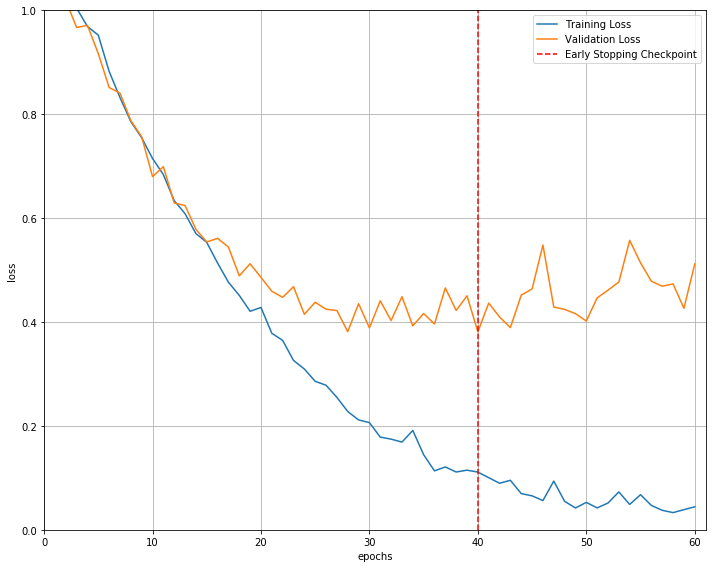

In [9]:
for run in range(runs):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    t_loss = train_loss[run][np.where(train_loss[run] > 0)]
    v_loss = val_loss[run][np.where(val_loss[run] > 0)]
    
    plt.plot(range(1,len(t_loss)+1),t_loss, label='Training Loss')
    plt.plot(range(1,len(v_loss)+1),v_loss,label='Validation Loss')

    # find position of lowest validation loss
    #print(np.where(v_loss == np.min(v_loss))[0][0])
    minposs = np.where(v_loss == np.min(v_loss))[0][0] + 1
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 1) # consistent scale
    plt.xlim(0, len(v_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('{}/loss_plot_fold{}_run{}.png'.format(model_name, fold, run), bbox_inches='tight',dpi=400)